<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры и довести метрику до 0.59. И необходимо проверить *F1*-меру на тестовой выборке.

Дополнительно измерим *AUC-ROC*, сравнивая её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:\\Users\\admin\\Desktop\\DS_yandex\\06_Отток клиентов\\Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# Удалим столбец 'RowNumber', который не несет никакой информации и заменяется индексом
data = data.drop('RowNumber', axis = 1)
# Изменим названия столбцов, переведем все в нижний регистр
data.set_axis([x.lower() for x in data.columns.to_list()], axis = 'columns', inplace = True)

В столбце 'tenure' почти 10% данных отсутствуют. Рассмотрим корреляцию данных этого столбца с остальными для выбора стратегии заполнения пропусков. Так же расмотрим распределение значений.

In [4]:
data[['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']]

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,42,2.0,0.00,1,1,1,101348.88
1,608,41,1.0,83807.86,1,0,1,112542.58
2,502,42,8.0,159660.80,3,1,0,113931.57
3,699,39,1.0,0.00,2,0,0,93826.63
4,850,43,2.0,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64
9996,516,35,10.0,57369.61,1,1,1,101699.77
9997,709,36,7.0,0.00,1,0,1,42085.58
9998,772,42,3.0,75075.31,2,1,0,92888.52


,creditscore,age,tenure,balance,numofproducts,estimatedsalary
creditscore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.001384
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.007201
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.010520
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,0.012797
numofproducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.014204
estimatedsalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,1.000000


<AxesSubplot:>

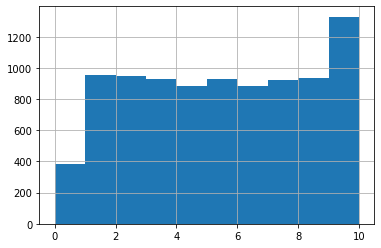

In [5]:
display(data[['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']].corr())
data['tenure'].hist()

Данные этого столбца независимы от других. Заполним пропуски случайными значениями для сохранения вида распределения.

<AxesSubplot:>

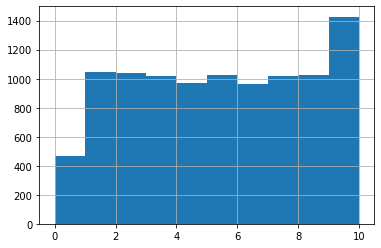

In [6]:
for i in data.query('tenure.isna()').index:
    data.loc[i, 'tenure'] = (np.random.randint(0, 10))
data['tenure'].hist()

## Исследование задачи

Рассмотрим сбалансированность классов целевого признака.

In [7]:
data['exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Признаки несбалансированны, соотношение положительного к отрицательному 1:4.

Найдем оптимальную модель без учета баланса классов целевого признака. Подготовим выборки:

In [8]:
# Помимо целевого призники в features не станем включать столбцы 'surname' и 'customerid', так как данные
# из этих столбов никак не могут повлиять на целевой признак
features = data.drop(['surname' ,'customerid', 'exited'], axis = 1)
features = pd.get_dummies(features, drop_first = True)
target = data['exited']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

print('Размер обучающей выборки', features_train.shape[0], 'строк.\nРазмер валидационной выборки', 
      features_valid.shape[0], 'строк.\nРазмер тестовой выборки', features_test.shape[0], 'строк.')

Размер обучающей выборки 6000 строк.
Размер валидационной выборки 2000 строк.
Размер тестовой выборки 2000 строк.


#### Дерево решений:

In [9]:
f1, auc, f1_b, auc_b = [], [], [], []

In [10]:
%%time
best_decisiontree_model = None
best_result, max_depth, auc_r = 0, 0, 0
for i in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result:
        best_decisiontree_model = model
        best_result = result
        max_depth = i
auc_r = roc_auc_score(target_valid, best_decisiontree_model.predict_proba(features_valid)[:,1])
f1.append(round(best_result, 4))
auc.append(round(auc_r, 4))

CPU times: total: 453 ms
Wall time: 444 ms


In [11]:
print('F1-мера наилучшей модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t\t при max_depth -', max_depth)
print('\nAUC-ROC наилучшей модели:\t\t\t\t', auc_r)

F1-мера наилучшей модели на валидационной выборке:	 0.5705614567526556
							 при max_depth - 6

AUC-ROC наилучшей модели:				 0.8169410352107139


#### Случайный лес:

In [12]:
%%time
best_randomforest_model = None
best_result, n_estimators, max_depth, auc_r = 0, 0, 0, 0
for i in range(10, 161, 10):
    for j in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=i, max_depth = j)
        model.fit(features_train, target_train)
        predict_valid = model.predict(features_valid)
        result = f1_score(target_valid, predict_valid)
        if result > best_result:
            best_randomforest_model = model
            best_result = result
            n_estimators = i
            max_depth = j
auc_r = roc_auc_score(target_valid, best_randomforest_model.predict_proba(features_valid)[:,1])
f1.append(round(best_result, 4))
auc.append(round(auc_r, 4))

CPU times: total: 2min 23s
Wall time: 2min 23s


In [13]:
print('F1-мера наилучшей модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t\t при n_estimators -', n_estimators)
print('\t\t\t\t\t\t\t     max_depth -', max_depth)
print('\nAUC-ROC наилучшей модели:\t\t\t\t', auc_r)

F1-мера наилучшей модели на валидационной выборке:	 0.5914634146341463
							 при n_estimators - 120
							     max_depth - 12

AUC-ROC наилучшей модели:				 0.8473859628959769


#### Логистическая регрессия:

In [14]:
%%time
best_logisticregression_model = None
best_result,auc_r, solver = 0, 0, None
for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(random_state=12345, solver=i)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result:
            best_logisticregression_model = model
            best_result = result
            solver = i
auc_r = roc_auc_score(target_valid, best_logisticregression_model.predict_proba(features_valid)[:,1])
f1.append(round(best_result, 4))
auc.append(round(auc_r, 4))

CPU times: total: 750 ms
Wall time: 677 ms


In [15]:
print('F1-мера модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t при solver -', solver)
print('\nAUC-ROC модели:\t\t\t\t\t', auc_r)

F1-мера модели на валидационной выборке:	 0.3152364273204904
						 при solver - newton-cg

AUC-ROC модели:					 0.7416116719796273


#### К-ближайших соседей:

In [16]:
%%time
best_kneighbors_model = None
best_result, n_neighbors, auc_r = 0, 0, 0
for i in range(1, 101):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result:
        best_kneighbors_model = model
        best_result = result
        n_neighbors = i
auc_r = roc_auc_score(target_valid, best_kneighbors_model.predict_proba(features_valid)[:,1])
f1.append(round(best_result, 4))
auc.append(round(auc_r, 4))

CPU times: total: 11.6 s
Wall time: 11.5 s


In [17]:
print('F1-мера модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t при n_neighbors -', n_neighbors)
print('\nAUC-ROC модели:\t\t\t\t\t', auc_r)

F1-мера модели на валидационной выборке:	 0.21980676328502416
						 при n_neighbors - 1

AUC-ROC модели:					 0.5080299300140939


### Вывод:

Лучше всего себя показала модель случайного леса, затем идут дерево решений и логистическая регрессия. Модель К-ближайших соседей показала очень низкие результаты.

## Борьба с дисбалансом

Обучим модели с учетом дисбаланса классов.

#### Дерево решений:

In [18]:
best_decisiontree_model = None
best_result, max_depth, auc_r = 0, 0, 0
for i in range(1, 21):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result:
        best_decisiontree_model = model
        best_result = result
        max_depth = i
auc_r = roc_auc_score(target_valid, best_decisiontree_model.predict_proba(features_valid)[:,1])
f1_b.append(round(best_result, 4))
auc_b.append(round(auc_r, 4))

In [19]:
print('F1-мера наилучшей модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t\t при max_depth -', max_depth)
print('\nAUC-ROC наилучшей модели:\t\t\t\t', auc_r)

F1-мера наилучшей модели на валидационной выборке:	 0.5963791267305644
							 при max_depth - 5

AUC-ROC наилучшей модели:				 0.8310244134068074


#### Случайный лес:

In [20]:
best_randomforest_model = None
best_result, n_estimators, max_depth, auc_r = 0, 0, 0, 0
for i in range(10, 161, 10):
    for j in range(1, 21):
        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=i, 
                                       max_depth = j, 
                                       class_weight = 'balanced')
        model.fit(features_train, target_train)
        predict_valid = model.predict(features_valid)
        result = f1_score(target_valid, predict_valid)
        if result > best_result:
            best_randomforest_model = model
            best_result = result
            n_estimators = i
            max_depth = j
auc_r = roc_auc_score(target_valid, best_randomforest_model.predict_proba(features_valid)[:,1])
f1_b.append(round(best_result, 4))
auc_b.append(round(auc_r, 4))

In [21]:
print('F1-мера наилучшей модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t\t при n_estimators -', n_estimators)
print('\t\t\t\t\t\t\t     max_depth -', max_depth)
print('\nAUC-ROC наилучшей модели:\t\t\t\t', auc_r)

F1-мера наилучшей модели на валидационной выборке:	 0.6344676180021953
							 при n_estimators - 110
							     max_depth - 8

AUC-ROC наилучшей модели:				 0.8548125139881079


#### Логистическай регрессия:

In [22]:
best_logisticregression_model = None
best_result, auc_r, solver = 0, 0, None
for i in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    model = LogisticRegression(random_state=12345, solver=i, class_weight = 'balanced')
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    result = f1_score(target_valid, predict_valid)
    if result > best_result:
            best_logisticregression_model = model
            best_result = result
            solver = i
auc_r = roc_auc_score(target_valid, best_logisticregression_model.predict_proba(features_valid)[:,1])
f1_b.append(round(best_result, 4))
auc_b.append(round(auc_r, 4))

In [23]:
print('F1-мера модели на валидационной выборке:\t', best_result)
print('\t\t\t\t\t\t при solver -', solver)
print('\nAUC-ROC модели:\t\t\t\t\t', auc_r)

F1-мера модели на валидационной выборке:	 0.4925124792013311
						 при solver - liblinear

AUC-ROC модели:					 0.7544973656990425


In [24]:
f1_b.append('None')
auc_b.append('None')

In [25]:
mln = ['DecisionTree', 'RandomForest', 'LogisticRegression', 'KNeighbors']
fa, fa_b = [], []
for x, y, i, j in zip(f1, auc, f1_b, auc_b): 
    fa.append(str(x) + ' (' + str(y) + ')')
    fa_b.append(str(i) + ' (' + str(j) + ')')
df = pd.DataFrame()
df['model'] = mln
df['f1_score(auc-roc)'] = fa
df['f1_score(auc-roc)_balanced'] = fa_b
display(df.sort_values(by = 'f1_score(auc-roc)', ascending = False))

,model,f1_score(auc-roc),f1_score(auc-roc)_balanced
1,RandomForest,0.5915 (0.8474),0.6345 (0.8548)
0,DecisionTree,0.5706 (0.8169),0.5964 (0.831)
2,LogisticRegression,0.3152 (0.7416),0.4925 (0.7545)
3,KNeighbors,0.2198 (0.508),None (None)


### Вывод

При учёте несбалансированности классов целевого признака и балансировании весов их значимости все модели, кроме К-ближайших соседей, показывают лучшие результаты, чем без учета баланса классов. Наилучшие показатели снова у Случайного леса: f1-мера - 0.6396, AUC-ROC - 0.8583.

## Тестирование модели

Протестируем модель "Случайный лес", показавшую наилучшие результаты.

In [26]:
predict_test = best_randomforest_model.predict(features_test)
print('F1-мера лучшей модели на тестовой выборке -', f1_score(target_test, predict_test))

F1-мера лучшей модели на тестовой выборке - 0.6137339055793991


In [27]:
predict_cons = pd.Series(1, index = range(len(target_test)))
print('F1-мера константы на тестовой выборке -', f1_score(target_test, predict_cons))

F1-мера константы на тестовой выборке - 0.3491539413949649


### Вывод

Выбранная нами модель показывает максимальный показатель F1-меры на валидационной и тестовой выборках, что доказывает правильность выбора модели и её гиперпараметров. Так же модель прошла проверку при сравнении с константой.

Данная модель готова к работе по предсказанию вероятности ухода клиента из банка.